In [2]:
import pandas as pd
import numpy as np
import os
import seaborn
from datetime import datetime
import time
import math
import matplotlib.pyplot as plt
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## Dataset import/cleaning

In [3]:
pb_only = False # SET TO TRUE TO USE ONLY PERSONAL BEST RECORDS

record_df = pd.DataFrame()
if not pb_only:
    # full record dataset
    record_df = pd.read_csv("out/all_records_pt_1.csv", index_col=[0])
    record_df = pd.concat([record_df, pd.read_csv("out/all_records_pt_2.csv", index_col=[0])], ignore_index=True)
else:
    # pb records only
    record_df = pd.read_csv("out/all_pbs.csv", index_col=[0])
    record_df = record_df.reset_index(drop=True)

# full user dataset
user_df = pd.read_csv("out/all_user_info.csv", index_col=[0])
user_df = user_df.reset_index(drop=True)

In [4]:
# construct more attributes
record_df["kps"] = record_df["inputs"] / record_df["final_time"] # keys per second
record_df["kpp"] = record_df["inputs"] / record_df["pieces_placed"] # keys per piece
record_df["percent_perf"] = record_df["finesse_perf"] / record_df["pieces_placed"] # percent of pieces placed with perfect finesse

In [5]:
# calculate time since account creation (users)
def calcTimePlayed(x):
    if x and isinstance(x, str):
        return time.time() - datetime.fromisoformat(x).timestamp()
    else:
        return math.nan
    
user_df["time_played"] = user_df["created_date"].apply(calcTimePlayed) # time since account creation

In [6]:
# drop the three records with over 5k finesse faults
crazy_outliers = record_df.loc[record_df["finesse_faults"] > 5000].index

for crazy_outlier in crazy_outliers:
    record_df = record_df.drop(crazy_outlier)

## Construct user attributes from records

In [7]:
# construct record-based user attrs
attrs_to_grab = ["final_time","pps","inputs","score","pieces_placed","singles","doubles","triples","quads","all_clears","finesse_faults","finesse_perf", "percent_perf", "kpp", "kps"]

for attr in attrs_to_grab:
    user_df = user_df.merge(record_df.groupby(by=["user_id"])[[attr]].mean().rename(columns={attr: attr+'_avg'}), left_on="id", right_on="user_id")

In [8]:
pb_record_df = record_df.loc[record_df["current_pb"] == True]
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del record_df
gc.collect()

0

In [9]:
for attr in attrs_to_grab:
    user_df = user_df.merge(pb_record_df.groupby(by=["user_id"])[[attr]].max().rename(columns={attr: attr+'_pb'}), left_on="id", right_on="user_id")

In [10]:
# explicitly delete and garbage-collect the records dataframe to reduce memory overhead
del pb_record_df
gc.collect()

0

In [11]:
user_df = user_df.dropna()

In [12]:
user_df.columns

Index(['id', 'username', 'rank', 'cohort', 'best_time', 'best_record',
       'country', 'created_date', 'xp', 'achievement_rating',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb'],
      dtype='object')

## Begin k-means clustering

In [21]:
features = user_df.loc[:, ['cohort', 'best_time',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb']].values
# cohorts = user_df.loc[:, ['cohort']].values

In [22]:
model = KMeans(init="random", n_clusters=60, max_iter=300)

In [23]:
model.fit(features)

KMeans(init='random', n_clusters=60)

## Analysis of clusters

In [25]:
cluster_df = pd.DataFrame(model.cluster_centers_)

cluster_df.columns = ['cohort', 'best_time',
       'TL_games_played', 'TL_games_won', 'TL_play_time', 'num_records',
       'time_played', 'final_time_avg', 'pps_avg', 'inputs_avg', 'score_avg',
       'pieces_placed_avg', 'singles_avg', 'doubles_avg', 'triples_avg',
       'quads_avg', 'all_clears_avg', 'finesse_faults_avg', 'finesse_perf_avg',
       'percent_perf_avg', 'kpp_avg', 'kps_avg', 'final_time_pb', 'pps_pb',
       'inputs_pb', 'score_pb', 'pieces_placed_pb', 'singles_pb', 'doubles_pb',
       'triples_pb', 'quads_pb', 'all_clears_pb', 'finesse_faults_pb',
       'finesse_perf_pb', 'percent_perf_pb', 'kpp_pb', 'kps_pb']

cluster_df["cluster_num"] = range(len(model.cluster_centers_))


In [28]:
cluster_df['cohort'].describe()

count     60.000000
mean     143.220417
std       10.727678
min       83.232284
25%      143.490094
50%      145.380361
75%      147.034292
max      162.866966
Name: cohort, dtype: float64

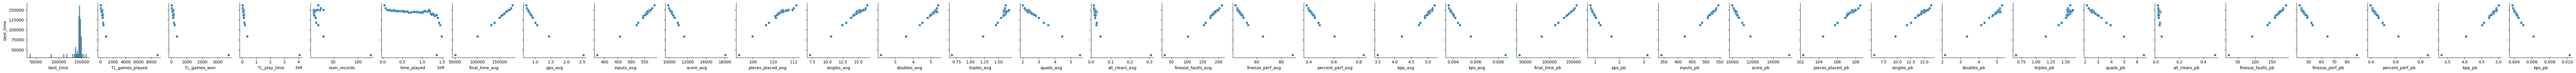

In [ ]:
# seaborn.pairplot(cluster_df, y_vars=["best_time"])

In [29]:
user_df["cluster"] = model.labels_

In [30]:
user_df.head()

,id,username,rank,cohort,best_time,best_record,country,created_date,xp,achievement_rating,...,doubles_pb,triples_pb,quads_pb,all_clears_pb,finesse_faults_pb,finesse_perf_pb,percent_perf_pb,kpp_pb,kps_pb,cluster
0,62a51397bf6ce5ce2e84b6cd,westl,1,13,13430.000000,66c273ca024b9a580d3c56a4,US,2022-06-11T22:13:43.355Z,1.236330e+07,445,...,5,0,6,1,0.0,101.0,1.000000,3.029703,0.022785,46
1,5e89fca2fd676e407898adbe,fortissim2,2,14,14008.333333,669633fe831a250b87499856,CA,2020-04-05T15:43:30.457Z,1.230626e+07,359,...,3,0,8,0,0.0,101.0,1.000000,2.534653,0.018275,10
3,5e7cbb652932b46c9c671ce4,icly,4,14,14385.000000,669d146c27be3114bd427572,VA,2020-03-26T14:25:41.228Z,1.347776e+07,251,...,0,0,10,0,1.0,100.0,0.990099,2.603960,0.018283,10
4,6030455395d4a33b1b6831bc,master101,5,14,14525.000000,6695d06c831a250b87faeb51,US,2021-02-19T23:10:11.728Z,1.776228e+07,273,...,0,1,9,0,2.0,100.0,0.990099,2.613861,0.018176,39
5,5f5dbcc4454e942b4fdfc5fa,vincehd,6,14,14531.666667,66963653831a250b874b753b,PH,2020-09-13T06:31:32.291Z,2.259369e+07,448,...,5,1,5,0,2.0,101.0,0.980583,2.485437,0.017617,52


[Text(0.5, 1.0, 'Correlation between user attributes')]

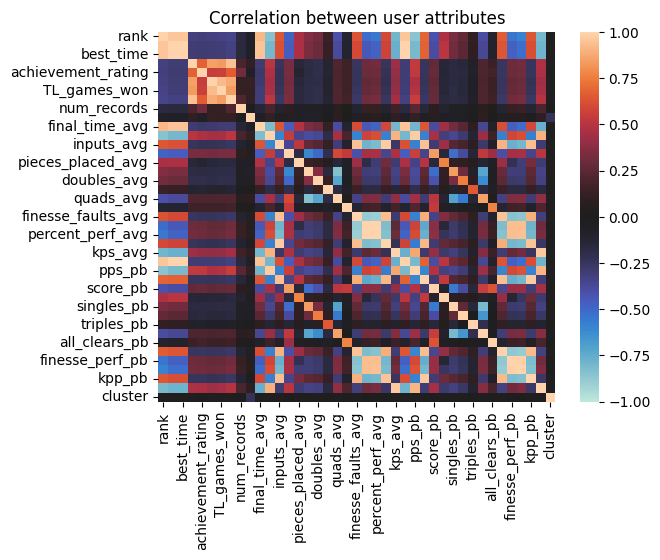

In [31]:
seaborn.heatmap(user_df.corr(numeric_only=True), cmap="icefire", center=0, vmin=-1, vmax=1).set(title="Correlation between user attributes")